<a href="https://colab.research.google.com/github/roofiifalria/Sentic-GCN/blob/main/GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation dan Data Prepocessing


In [ ]:
# Install necessary libraries
!pip install nltk spacy scikit-learn tensorflow-cpu transformers
!python -m spacy download en_core_web_sm

import re
import nltk
import spacy
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import warnings
from tabulate import tabulate
import spacy
import torch.nn.functional as F
warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Download NLTK stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Load spaCy English model for dependency parsing
nlp = spacy.load('en_core_web_sm')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load your data
train_data = pd.read_csv('train_GCN.csv')
train_data = train_data.sample(frac=0.01, random_state=42).reset_index(drop=True)
test_data = pd.read_csv('test_GCN.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Function for text preprocessing
def preprocess_text(sentence):
    sentence = sentence.lower()  # 1. Lowercasing
    sentence = re.sub(r'[^\w\s]', '', sentence)  # 2. Remove punctuation

    # Check if the number of words exceeds 512
    words = word_tokenize(sentence)
    if len(words) > 512:
        return None  # Or return '' if you prefer

    words = [word for word in words if word not in stop_words]  # 4. Remove stopwords
    doc = nlp(" ".join(words))  # 5. Lemmatization
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

<ipython-input-49-28f55aed4ee9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sentiment'] = train_data['sentiment'].replace({'positive': 0, 'neutral': 1, 'negative': 2})


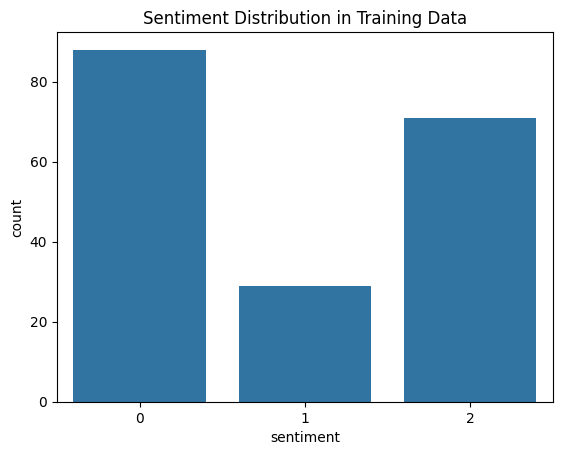

In [ ]:
# Handle missing data
train_data.dropna(subset=['review'], inplace=True)
test_data.dropna(subset=['review'], inplace=True)

train_data['cleaned_sentence'] = train_data['review'].apply(preprocess_text)

# Drop rows where cleaned_sentence is None
train_data = train_data[train_data['cleaned_sentence'].notna()]

# Convert sentiments to numbers
train_data['sentiment'] = train_data['sentiment'].replace({'positive': 0, 'neutral': 1, 'negative': 2})

# Visualize sentiment distribution
sns.countplot(data=train_data, x='sentiment')
plt.title('Sentiment Distribution in Training Data')
plt.show()

In [ ]:
# Print output
print("\nTraining Data After Preprocessing:")
print(tabulate(train_data.head(), headers='keys', tablefmt='sqlite'))  # Display first few rows


Training Data After Preprocessing:
    review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# BERT and BiLSTM

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)  # *2 karena bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out)
        return out

class SentenceDataset(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]

def get_sentence_vectors(sentence, bert_model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        bert_outputs = bert_model(**inputs)

    # Ambil semua token embeddings dan juga ID token untuk mendeteksi kata-kata
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())

    # Hapus [CLS] dan [SEP] dari tokens dan embeddings
    if "[CLS]" in tokens: tokens.remove("[CLS]")
    if "[SEP]" in tokens: tokens.remove("[SEP]")

    embeddings = bert_outputs.last_hidden_state.squeeze(0)[1:-1]  # Hapus embedding untuk [CLS] dan [SEP]

    return tokens, embeddings

def create_contextualized_word_representations(sentence, bert_model, tokenizer, bilstm_model):
    # Dapatkan token dan vektor kalimat dari BERT
    tokens, sentence_vector = get_sentence_vectors(sentence, bert_model, tokenizer)

    # Dapatkan representasi kontekstual dari BiLSTM
    contextualized_word_representations = bilstm_model(sentence_vector.unsqueeze(0))  # Menambah dimensi batch

    return tokens, contextualized_word_representations.squeeze(0)  # Menghapus dimensi batch


# Function to build sentence graph
def build_sentence_graph(sentence, contextualized_representations, nlp):
    doc = nlp(sentence)
    num_words = len(doc)

    # Initialize adjacency matrix
    A = torch.zeros((num_words, num_words))

    # Fill adjacency matrix based on dependency parse
    for token in doc:
        A[token.i, token.i] = 1  # Self-loop
        if token.head.i != token.i:
            A[token.i, token.head.i] = 1
            A[token.head.i, token.i] = 1

    # Node feature matrix
    Q = contextualized_representations[:num_words, :]

    return A, Q

In [ ]:
# Parameters
input_dim = 768  # Dimensi output model BERT (dimensi embedding CLS)
hidden_dim = 128
output_dim = 128  # Dimensi dari vektor kontekstual

# Initialize BiLSTM model
bilstm_model = BiLSTM(input_dim, hidden_dim, output_dim)

sentence_dataset = SentenceDataset(train_data['cleaned_sentence'].tolist())  # Convert Series to list

# DataLoader to handle batches of sentences
batch_size = 1
dataloader = DataLoader(sentence_dataset, batch_size=batch_size, shuffle=False)

# List to hold contextualized representations, sentence graphs, and token lists
contextualized_representations_list = []
adjacency_matrices_list = []
node_feature_matrices_list = []
tokenized_sentences_list = []  # To store tokenized words

# Set the model to evaluation mode (to deactivate dropout, etc.)
bilstm_model.eval()

# Iterate over batches of sentences with tqdm for progress
with torch.no_grad():  # Non-training mode
    for batch_sentences in tqdm(dataloader, desc="Processing Sentences", unit="batch"):
        for sentence in batch_sentences:
            # Create contextualized word representations and tokens for the batch
            tokens, contextualized_representations = create_contextualized_word_representations(sentence, bert_model, tokenizer, bilstm_model)

            # Build the sentence graph (adjacency matrix A and node feature matrix Q)
            A, Q = build_sentence_graph(sentence, contextualized_representations, nlp)

            # Append the tokenized words and contextualized representations to the list
            tokenized_sentences_list.append(tokens)  # Save tokens
            adjacency_matrices_list.append(A.numpy())  # Save adjacency matrix
            node_feature_matrices_list.append(Q.numpy())  # Save node features

Processing Sentences: 100%|██████████| 188/188 [01:36<00:00,  1.95batch/s]


In [ ]:
# Add the adjacency matrices and node feature matrices to train_data
train_data['adjacency_matrices'] = adjacency_matrices_list
train_data['node_feature_matrices'] = node_feature_matrices_list
train_data['tokens'] = tokenized_sentences_list

# Check the result
print(train_data[['cleaned_sentence', 'adjacency_matrices', 'node_feature_matrices']])
# Print the first adjacency matrix from the train_data DataFrame
print(train_data['node_feature_matrices'].iloc[0].shape)
print(train_data['tokens'].iloc[0])

                                      cleaned_sentence  \
0    even awful 1 much film everything form start f...   
2    I ve see movie time one exceptional you ll wat...   
3    movie truly capture feel freedomand freedom in...   
4    there s much anyone say flickthe plot quite si...   
6    check witty honest portrayal bizarre family ha...   
..                                                 ...   
202  gurinda chadas semiautobiographical film 2002 ...   
204  componenta also offer fiveyear subordinate loa...   
205  movie bad good unintentionally funny way could...   
206  read well story solid volckman feel fail waybr...   
207  act film old school corny stiff irene dunne lu...   

                                    adjacency_matrices  \
0    [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2    [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3    [[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4    [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
6    [[1.0, 0

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")

class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)  # *2 karena bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out)
        return out

class SentenceDataset(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]

def get_sentence_vectors(sentence, bert_model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        bert_outputs = bert_model(**inputs)

    # Ambil semua token embeddings dan juga ID token untuk mendeteksi kata-kata
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())

    # Hapus [CLS] dan [SEP] dari tokens dan embeddings
    if "[CLS]" in tokens: tokens.remove("[CLS]")
    if "[SEP]" in tokens: tokens.remove("[SEP]")

    embeddings = bert_outputs.last_hidden_state.squeeze(0)[1:-1]  # Hapus embedding untuk [CLS] dan [SEP]

    return tokens, embeddings

def create_contextualized_word_representations(sentence, bert_model, tokenizer, bilstm_model):
    tokens, sentence_vector = get_sentence_vectors(sentence, bert_model, tokenizer)
    contextualized_word_representations = bilstm_model(sentence_vector.unsqueeze(0))  # Menambah dimensi batch
    return tokens, contextualized_word_representations.squeeze(0)  # Menghapus dimensi batch

# Function to build sentence graph
def build_sentence_graph(sentence, tokens, contextualized_representations, nlp):
    doc = nlp(sentence)
    num_words = len(tokens)

    # Initialize adjacency matrix
    A = torch.zeros((num_words, num_words))

    # Fill adjacency matrix based on dependency parse
    for token in doc:
        if token.text in tokens:  # Sesuaikan dengan token dari BERT
            idx = tokens.index(token.text)  # Cari indeks token
            A[idx, idx] = 1  # Self-loop
            if token.head.text in tokens:
                head_idx = tokens.index(token.head.text)
                A[idx, head_idx] = 1
                A[head_idx, idx] = 1

    # Node feature matrix
    Q = contextualized_representations[:num_words, :]  # Sesuaikan ukuran dengan token yang sesuai

    return A, Q

# Parameters
input_dim = 768  # Dimensi output model BERT (dimensi embedding CLS)
hidden_dim = 128
output_dim = 128  # Dimensi dari vektor kontekstual

# Initialize BiLSTM model
bilstm_model = BiLSTM(input_dim, hidden_dim, output_dim)

sentence_dataset = SentenceDataset(train_data['cleaned_sentence'].tolist())  # Convert Series to list

# DataLoader to handle batches of sentences
batch_size = 1
dataloader = DataLoader(sentence_dataset, batch_size=batch_size, shuffle=False)

# List to hold contextualized representations and sentence graphs
tokenized_sentences_list = []
contextualized_representations_list = []
adjacency_matrices_list = []
node_feature_matrices_list = []

# Set the model to evaluation mode (to deactivate dropout, etc.)
bilstm_model.eval()

# Iterate over batches of sentences with tqdm for progress
with torch.no_grad():  # Non-training mode
    for batch_sentences in tqdm(dataloader, desc="Processing Sentences", unit="batch"):
        for sentence in batch_sentences:
            # Create contextualized word representations for the batch
            tokens, contextualized_representations = create_contextualized_word_representations(sentence, bert_model, tokenizer, bilstm_model)

            # Build the sentence graph (adjacency matrix A and node feature matrix Q)
            A, Q = build_sentence_graph(sentence, tokens, contextualized_representations, nlp)

            # Append the tokenized words and contextualized representations to the list
            tokenized_sentences_list.append(tokens)  # Save tokens
            adjacency_matrices_list.append(A.numpy())  # Save adjacency matrix
            node_feature_matrices_list.append(Q.numpy())  # Save node features

# Add the tokenized sentences, adjacency matrices, and node feature matrices to train_data
train_data['tokens'] = tokenized_sentences_list
train_data['adjacency_matrices'] = adjacency_matrices_list
train_data['node_feature_matrices'] = node_feature_matrices_list

# Check the result
print(train_data[['cleaned_sentence', 'tokens', 'adjacency_matrices', 'node_feature_matrices']])


Processing Sentences: 100%|██████████| 188/188 [01:38<00:00,  1.92batch/s]


                                      cleaned_sentence  \
0    even awful 1 much film everything form start f...   
2    I ve see movie time one exceptional you ll wat...   
3    movie truly capture feel freedomand freedom in...   
4    there s much anyone say flickthe plot quite si...   
6    check witty honest portrayal bizarre family ha...   
..                                                 ...   
202  gurinda chadas semiautobiographical film 2002 ...   
204  componenta also offer fiveyear subordinate loa...   
205  movie bad good unintentionally funny way could...   
206  read well story solid volckman feel fail waybr...   
207  act film old school corny stiff irene dunne lu...   

                                                tokens  \
0    [even, awful, 1, much, film, everything, form,...   
2    [i, ve, see, movie, time, one, exceptional, yo...   
3    [movie, truly, capture, feel, freedom, ##and, ...   
4    [there, s, much, anyone, say, flick, ##the, pl...   
6    [check, 

# GCN Model



In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, H, A):
        # Multiplying Adjacency matrix with Node Features first
        support = torch.matmul(A, H)
        # Now applying the linear transformation with weight matrix W
        out = self.linear(support)
        return F.relu(out)

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, H, A_hat):
        H1 = self.gcn1(H, A_hat)
        H2 = self.gcn2(H1, A_hat)
        return H2

class SentimentClassifier(nn.Module):
    def __init__(self, gcn_input_dim, gcn_hidden_dim, gcn_output_dim, num_classes):
        super(SentimentClassifier, self).__init__()
        self.gcn = GCN(gcn_input_dim, gcn_hidden_dim, gcn_output_dim)
        self.fc = nn.Linear(gcn_output_dim, num_classes)

    def forward(self, H, A_hat):
        gcn_output = self.gcn(H, A_hat)
        # Apply pooling across node features (average pooling over nodes)
        gcn_output_pooled = torch.mean(gcn_output, dim=0)
        logits = self.fc(gcn_output_pooled)
        return F.log_softmax(logits, dim=1)